Experimenting different clustering algorithms to create data driven climate zones. The Koppen system has 5 major zones, and 14 different zones in all.

In [75]:
import xarray as xr
from dask.distributed import Client
from dask_ml.cluster import KMeans
# import geopandas as gpd
from shapely.geometry import Point
# %matplotlib inline
import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

In [4]:
client = Client()
client

/home/dyllanjr/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43955 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43983' processes=4 threads=12, memory=50.56 GB>

In [5]:
%ls

dask-worker-space/                monthly_era5_2018.nc
era5_2018_prepared.nc             monthly_era5_2018_subset.nc
feature_engineering_global.ipynb  README.md
global_clustering.ipynb           x_array_dask_tests.ipynb
load_data.ipynb


In [6]:
ds = xr.open_dataset('era5_2018_prepared.nc')

In [7]:
ds

<xarray.Dataset>
Dimensions:          (latitude: 721, longitude: 1440)
Coordinates:
  * longitude        (longitude) float32 0.0 0.25 0.5 ... 359.25 359.5 359.75
  * latitude         (latitude) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    annual_max_t2m   (latitude, longitude) float32 ...
    annual_max_tp    (latitude, longitude) float32 ...
    annual_mean_t2m  (latitude, longitude) float32 ...
    annual_mean_tp   (latitude, longitude) float32 ...
    annual_min_t2m   (latitude, longitude) float32 ...
    annual_min_tp    (latitude, longitude) float32 ...
    sum_max_t2m      (latitude, longitude) float32 ...
    sum_max_tp       (latitude, longitude) float32 ...
    sum_mean_t2m     (latitude, longitude) float32 ...
    sum_mean_tp      (latitude, longitude) float32 ...
    sum_min_t2m      (latitude, longitude) float32 ...
    sum_min_tp       (latitude, longitude) float32 ...
    win_max_t2m      (latitude, longitude) float32 ...
    win_max_tp       (latitude, longitude) float32 ...
    win_mean_t2m     (latitude, longitude) float32 ...
    win_mean_tp      (latitude, longitude) float32 ...
    win_min_t2m      (latitude, longitude) float32 ...
    win_min_tp       (latitude, longitude) float32 ...

In [87]:
df = ds.to_dask_dataframe()
#note to self: Don't write into existing netcdf files!
t2m_cols = ['annual_max_t2m', 'annual_mean_t2m', 'annual_min_t2m', 'sum_max_t2m', 'sum_mean_t2m', 'sum_min_t2m','win_max_t2m', 'win_mean_t2m', 'win_min_t2m']

In [88]:
(df['win_max_t2m'] > 0).any().compute()

True

In [89]:
#convert to celcius fronm kelvin
for col in t2m_cols:
    df[col] = df[col] - 273.15

In [90]:
df.tail()

latitude  longitude  annual_max_t2m  annual_max_tp  annual_mean_t2m  \
1038235     -90.0     358.75      -23.824295       0.000446       -43.597733   
1038236     -90.0     359.00      -23.824295       0.000446       -43.597733   
1038237     -90.0     359.25      -23.824295       0.000446       -43.597733   
1038238     -90.0     359.50      -23.824295       0.000446       -43.597733   
1038239     -90.0     359.75      -23.824295       0.000446       -43.597733   

         annual_mean_tp  annual_min_t2m  annual_min_tp  sum_max_t2m  \
1038235        0.000226      -56.892456       0.000064   -23.824295   
1038236        0.000226      -56.892456       0.000064   -23.824295   
1038237        0.000226      -56.892456       0.000064   -23.824295   
1038238        0.000226      -56.892456       0.000064   -23.824295   
1038239        0.000226      -56.892456       0.000064   -23.824295   

         sum_max_tp  sum_mean_t2m  sum_mean_tp  sum_min_t2m  sum_min_tp  \
1038235    0.000446    -35.855881     0.000256   -45.634857    0.000097   
1038236    0.000446    -35.855881     0.000256   -45.634857    0.000097   
1038237    0.000446    -35.855881     0.000256   -45.634857    0.000097   
1038238    0.000446    -35.855881     0.000256   -45.634857    0.000097   
1038239    0.000446    -35.855881     0.000256   -45.634857    0.000097   

         win_max_t2m  win_max_tp  win_mean_t2m  win_mean_tp  win_min_t2m  \
1038235   -45.320236    0.000402    -51.339569     0.000195   -56.892456   
1038236   -45.320236    0.000402    -51.339569     0.000195   -56.892456   
1038237   -45.320236    0.000402    -51.339569     0.000195   -56.892456   
1038238   -45.320236    0.000402    -51.339569     0.000195   -56.892456   
1038239   -45.320236    0.000402    -51.339569     0.000195   -56.892456   

         win_min_tp  
1038235    0.000064  
1038236    0.000064  
1038237    0.000064  
1038238    0.000064  
1038239    0.000064

In [12]:
X = df.drop(['latitude', 'longitude'], axis=1)

In [13]:
X.head()

annual_max_t2m  annual_max_tp  annual_mean_t2m  annual_mean_tp  \
0         0.81131       0.001726       -12.140656        0.000743   
1         0.81131       0.001726       -12.140656        0.000743   
2         0.81131       0.001726       -12.140656        0.000743   
3         0.81131       0.001726       -12.140656        0.000743   
4         0.81131       0.001726       -12.140656        0.000743   

   annual_min_t2m  annual_min_tp  sum_max_t2m  sum_max_tp  sum_mean_t2m  \
0      -25.602249       0.000174      0.81131    0.001726     -4.907593   
1      -25.602249       0.000174      0.81131    0.001726     -4.907593   
2      -25.602249       0.000174      0.81131    0.001726     -4.907593   
3      -25.602249       0.000174      0.81131    0.001726     -4.907593   
4      -25.602249       0.000174      0.81131    0.001726     -4.907593   

   sum_mean_tp  sum_min_t2m  sum_min_tp  win_max_t2m  win_max_tp  \
0       0.0009   -19.159027    0.000396    -8.158722    0.001255   
1       0.0009   -19.159027    0.000396    -8.158722    0.001255   
2       0.0009   -19.159027    0.000396    -8.158722    0.001255   
3       0.0009   -19.159027    0.000396    -8.158722    0.001255   
4       0.0009   -19.159027    0.000396    -8.158722    0.001255   

   win_mean_t2m  win_mean_tp  win_min_t2m  win_min_tp  
0    -19.373703     0.000586   -25.602249    0.000174  
1    -19.373703     0.000586   -25.602249    0.000174  
2    -19.373703     0.000586   -25.602249    0.000174  
3    -19.373703     0.000586   -25.602249    0.000174  
4    -19.373703     0.000586   -25.602249    0.000174

In [14]:
X.isnull().any().compute()

annual_max_t2m     False
annual_max_tp      False
annual_mean_t2m    False
annual_mean_tp     False
annual_min_t2m     False
annual_min_tp      False
sum_max_t2m        False
sum_max_tp         False
sum_mean_t2m       False
sum_mean_tp        False
sum_min_t2m        False
sum_min_tp         False
win_max_t2m        False
win_max_tp         False
win_mean_t2m       False
win_mean_tp        False
win_min_t2m        False
win_min_tp         False
dtype: bool

In [15]:
count_nan = len(X) - X.count()

In [17]:
count_nan.compute()
#I think this must be because I didn't include latitude=0 in one of the hemispheres

annual_max_t2m     0
annual_max_tp      0
annual_mean_t2m    0
annual_mean_tp     0
annual_min_t2m     0
annual_min_tp      0
sum_max_t2m        0
sum_max_tp         0
sum_mean_t2m       0
sum_mean_tp        0
sum_min_t2m        0
sum_min_tp         0
win_max_t2m        0
win_max_tp         0
win_mean_t2m       0
win_mean_tp        0
win_min_t2m        0
win_min_tp         0
dtype: int64

In [18]:
#let's tak ea look at 5 major zones
km = KMeans(n_clusters = 5)
km.fit(X)

KMeans(n_clusters=5)

In [19]:
labels = km.predict(X)
labels

dask.array<astype, shape=(1038240,), dtype=int32, chunksize=(1038240,), chunktype=numpy.ndarray>

In [20]:
type(labels.compute())

numpy.ndarray

In [21]:
geo_df = gpd.GeoDataFrame(labels.compute(),
                          crs="EPSG:4326", 
                          geometry=[Point(xy) for xy in zip(df.longitude - , df.latitude)])

SyntaxError: invalid syntax (<ipython-input-21-ea78b47c14ef>, line 3)

In [46]:
type(labels)

dask.array.core.Array

In [72]:
geo_df = gpd.GeoDataFrame(labels.compute(),
                          crs="EPSG:4326", 
                          geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])

geo_df[0]
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

#boundary lines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, color='lightgrey', linewidth=1, zorder=1)

#plot 
geo_df.plot(ax=ax, column=0, alpha=.5, cmap='viridis', 
            linewidth=.8, zorder = 2)


In [73]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [74]:
geo_df

0                 geometry
0        4     POINT (0.000 90.000)
1        4     POINT (0.250 90.000)
2        4     POINT (0.500 90.000)
3        4     POINT (0.750 90.000)
4        4     POINT (1.000 90.000)
...     ..                      ...
1038235  0  POINT (358.750 -90.000)
1038236  0  POINT (359.000 -90.000)
1038237  0  POINT (359.250 -90.000)
1038238  0  POINT (359.500 -90.000)
1038239  0  POINT (359.750 -90.000)

[1038240 rows x 2 columns]

In [22]:
df.head()

latitude  longitude  annual_max_t2m  annual_max_tp  annual_mean_t2m  \
0      90.0       0.00         0.81131       0.001726       -12.140656   
1      90.0       0.25         0.81131       0.001726       -12.140656   
2      90.0       0.50         0.81131       0.001726       -12.140656   
3      90.0       0.75         0.81131       0.001726       -12.140656   
4      90.0       1.00         0.81131       0.001726       -12.140656   

   annual_mean_tp  annual_min_t2m  annual_min_tp  sum_max_t2m  sum_max_tp  \
0        0.000743      -25.602249       0.000174      0.81131    0.001726   
1        0.000743      -25.602249       0.000174      0.81131    0.001726   
2        0.000743      -25.602249       0.000174      0.81131    0.001726   
3        0.000743      -25.602249       0.000174      0.81131    0.001726   
4        0.000743      -25.602249       0.000174      0.81131    0.001726   

   sum_mean_t2m  sum_mean_tp  sum_min_t2m  sum_min_tp  win_max_t2m  \
0     -4.907593       0.0009   -19.159027    0.000396    -8.158722   
1     -4.907593       0.0009   -19.159027    0.000396    -8.158722   
2     -4.907593       0.0009   -19.159027    0.000396    -8.158722   
3     -4.907593       0.0009   -19.159027    0.000396    -8.158722   
4     -4.907593       0.0009   -19.159027    0.000396    -8.158722   

   win_max_tp  win_mean_t2m  win_mean_tp  win_min_t2m  win_min_tp  
0    0.001255    -19.373703     0.000586   -25.602249    0.000174  
1    0.001255    -19.373703     0.000586   -25.602249    0.000174  
2    0.001255    -19.373703     0.000586   -25.602249    0.000174  
3    0.001255    -19.373703     0.000586   -25.602249    0.000174  
4    0.001255    -19.373703     0.000586   -25.602249    0.000174

In [99]:
df['clust'] = labels

In [30]:
clusters = df.groupby('clust')


In [32]:
clusters.annual_max_t2m.mean().compute()

clust
0    13.232795
1   -25.565710
2     4.914888
3   -10.784828
4    26.496101
Name: annual_max_t2m, dtype: float64

In [54]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


In [36]:
df.longitude.min().compute()

0.0

In [121]:
np.arange(0,5)

array([0, 1, 2, 3, 4])

In [38]:
%matplotlib inline

In [81]:
df['longitude'] = lons

In [126]:
plt.figure(figsize=(20,20))
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
cmap = plt.cm.viridis
norm = plt.Normalize(df.clust.values.min(), df.clust.values.max())

for i in np.arange(0,5):
    cluster = df[df.clust == i]
    lons = cluster.longitude.to_dask_array(lengths=True).compute()
    lats = cluster.latitude.to_dask_array(lengths=True).compute()
    x, y = m(lons, lats) #transform coords
    plt.scatter(x, y, c=cluster.clust.to_dask_array(lengths=True), label=i)
    
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()
#I think I'm just going to create a legend manually


<ipython-input-126-601b418cf017>:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=0)


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


<ipython-input-114-b33cfa83fe98>:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=0)


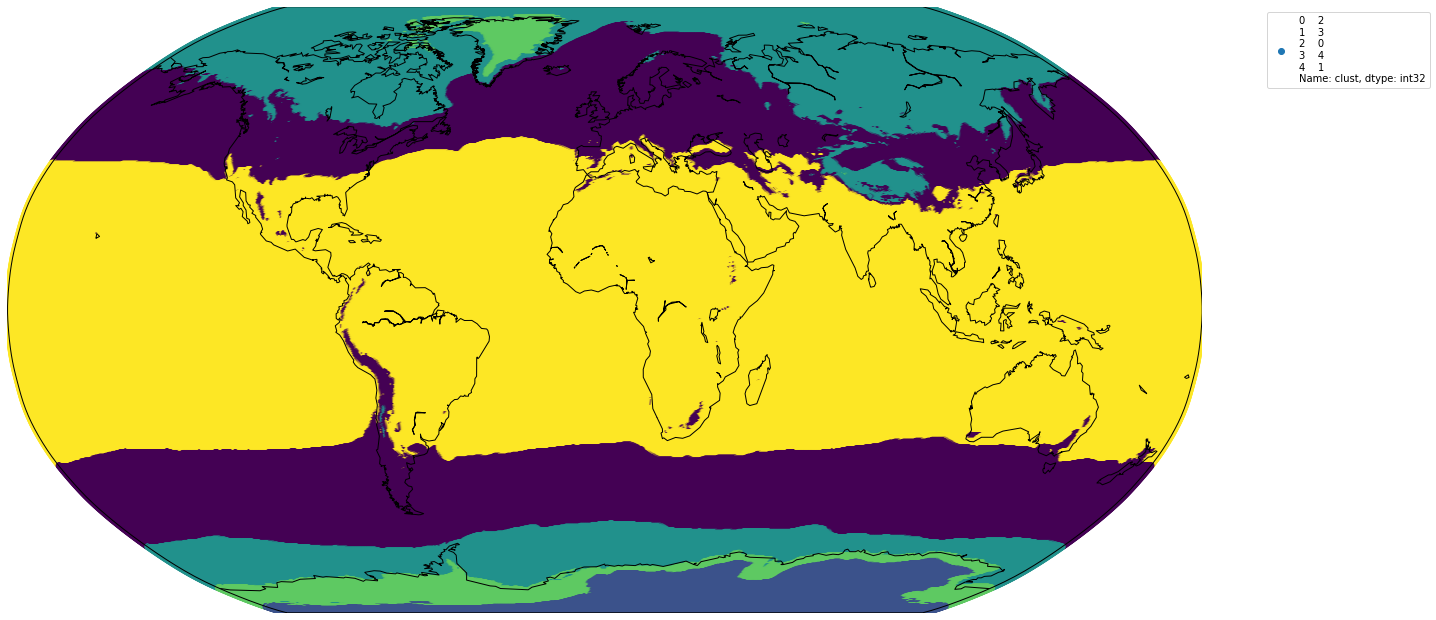

In [114]:
plt.figure(figsize=(20,20))
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
lons = df.longitude.to_dask_array(lengths=True).compute()
lats = df.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=df.clust.to_dask_array(lengths=True))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [85]:
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()

<ipython-input-85-803a9eb5b43b>:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin',lon_0=0,resolution='c')


If need to convert the longitude from [0, 360] to [+-180]:

In [101]:
# lons = np.mod(df.longitude - 180.0, 360.0) - 180.0 #converts lons


This clustering seems to pick up on much more of the intricacies in the polar regions compared to the koppen system. Now lets see what happens if we increase the number of clusters by two since the polar region seems to take up 3 clusters.

In [102]:
km = KMeans(n_clusters = 7)
km.fit(X)

KMeans(n_clusters=7)

In [103]:
labels = km.predict(X)
labels

dask.array<astype, shape=(1038240,), dtype=int32, chunksize=(1038240,), chunktype=numpy.ndarray>

In [108]:
plt.figure(figsize=(20,20))
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
lons = df.longitude.to_dask_array(lengths=True).compute()
lats = df.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=labels)
plt.show()

<ipython-input-108-62a2fdf781c5>:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=0)


In [127]:
#Let's try adding two more clusters

<ipython-input-129-369572c8e5a5>:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=0)


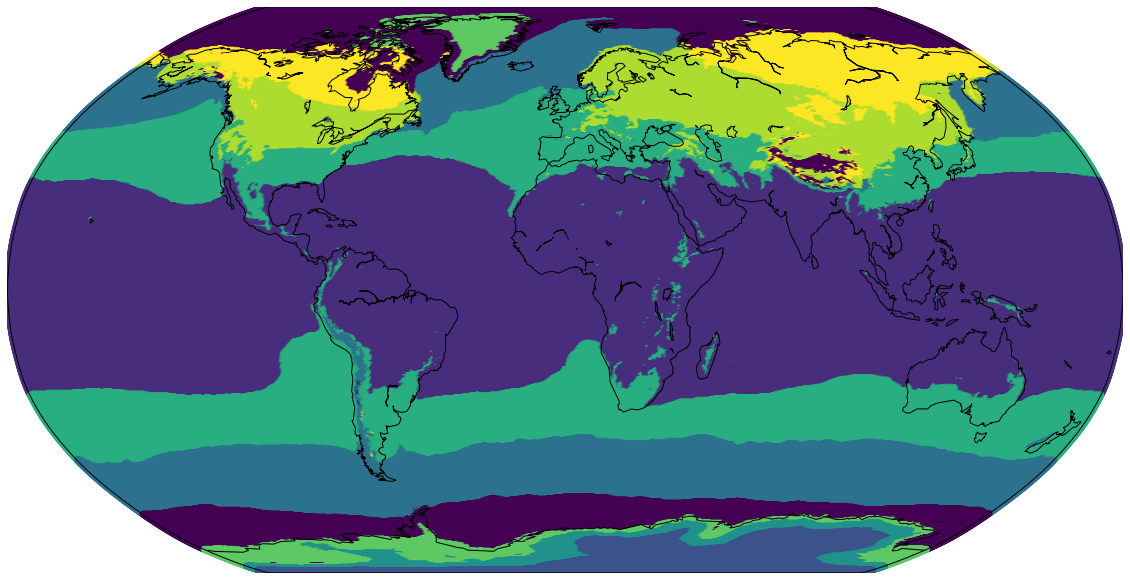

In [129]:
km = KMeans(n_clusters = 9)
km.fit(X)
labels = km.predict(X)
labels
plt.figure(figsize=(20,20))
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
lons = df.longitude.to_dask_array(lengths=True).compute()
lats = df.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=labels)
plt.show()

<ipython-input-131-f7c4bf3bef2c>:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=0)


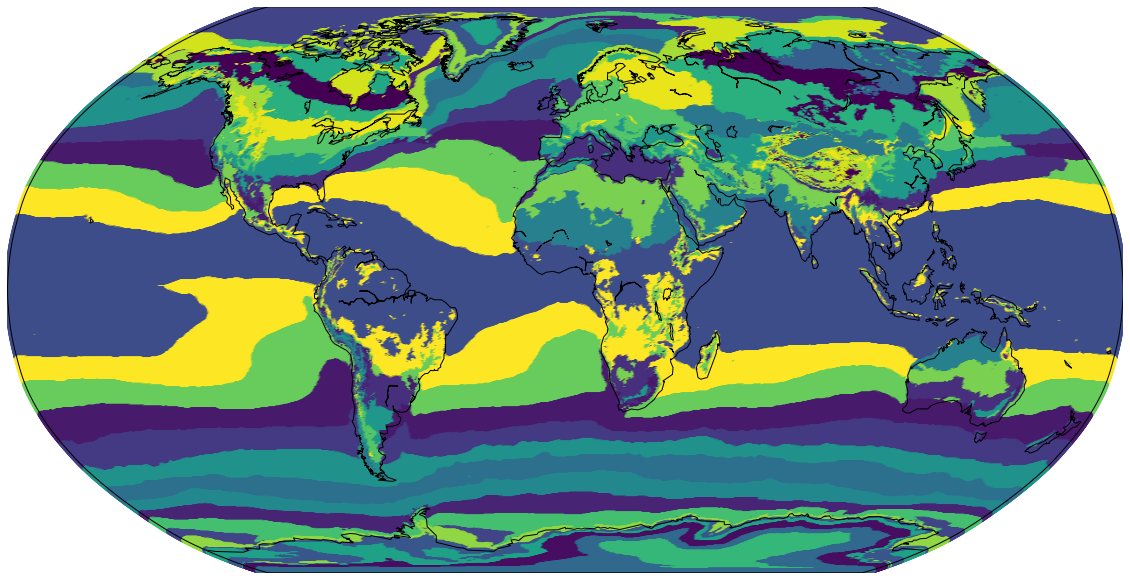

In [131]:
#There are 31 different groups in the original koppen system, let's compare that to 31 clusters.
km = KMeans(n_clusters = 31)
km.fit(X)
labels = km.predict(X)
labels


<ipython-input-135-6b4adb1d463c>:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=0)


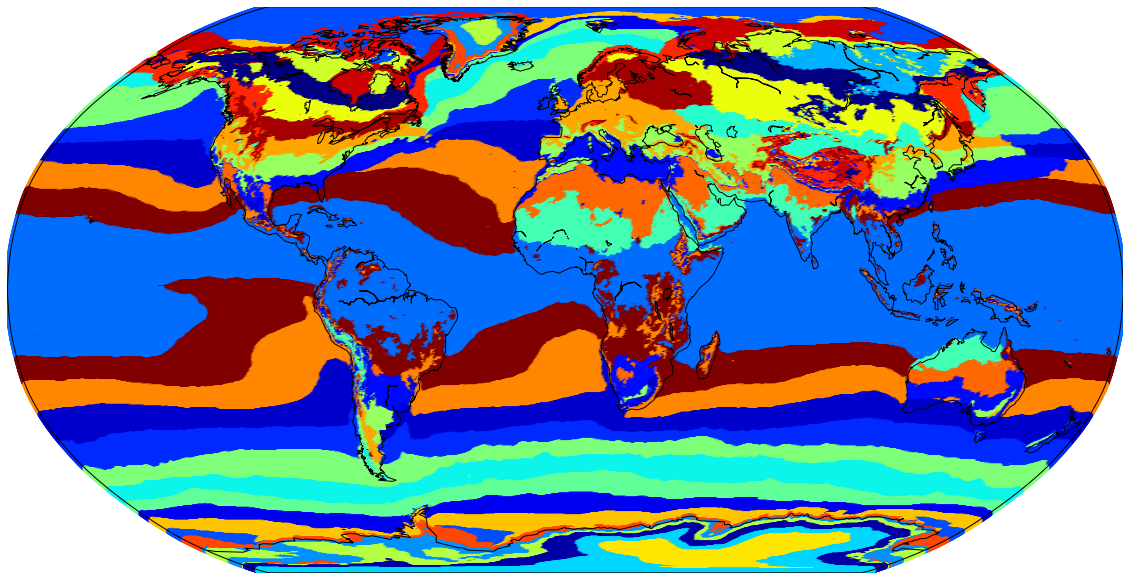

In [135]:
plt.figure(figsize=(20,20))
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
lons = df.longitude.to_dask_array(lengths=True).compute()
lats = df.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=labels, cmap='jet')
plt.show()

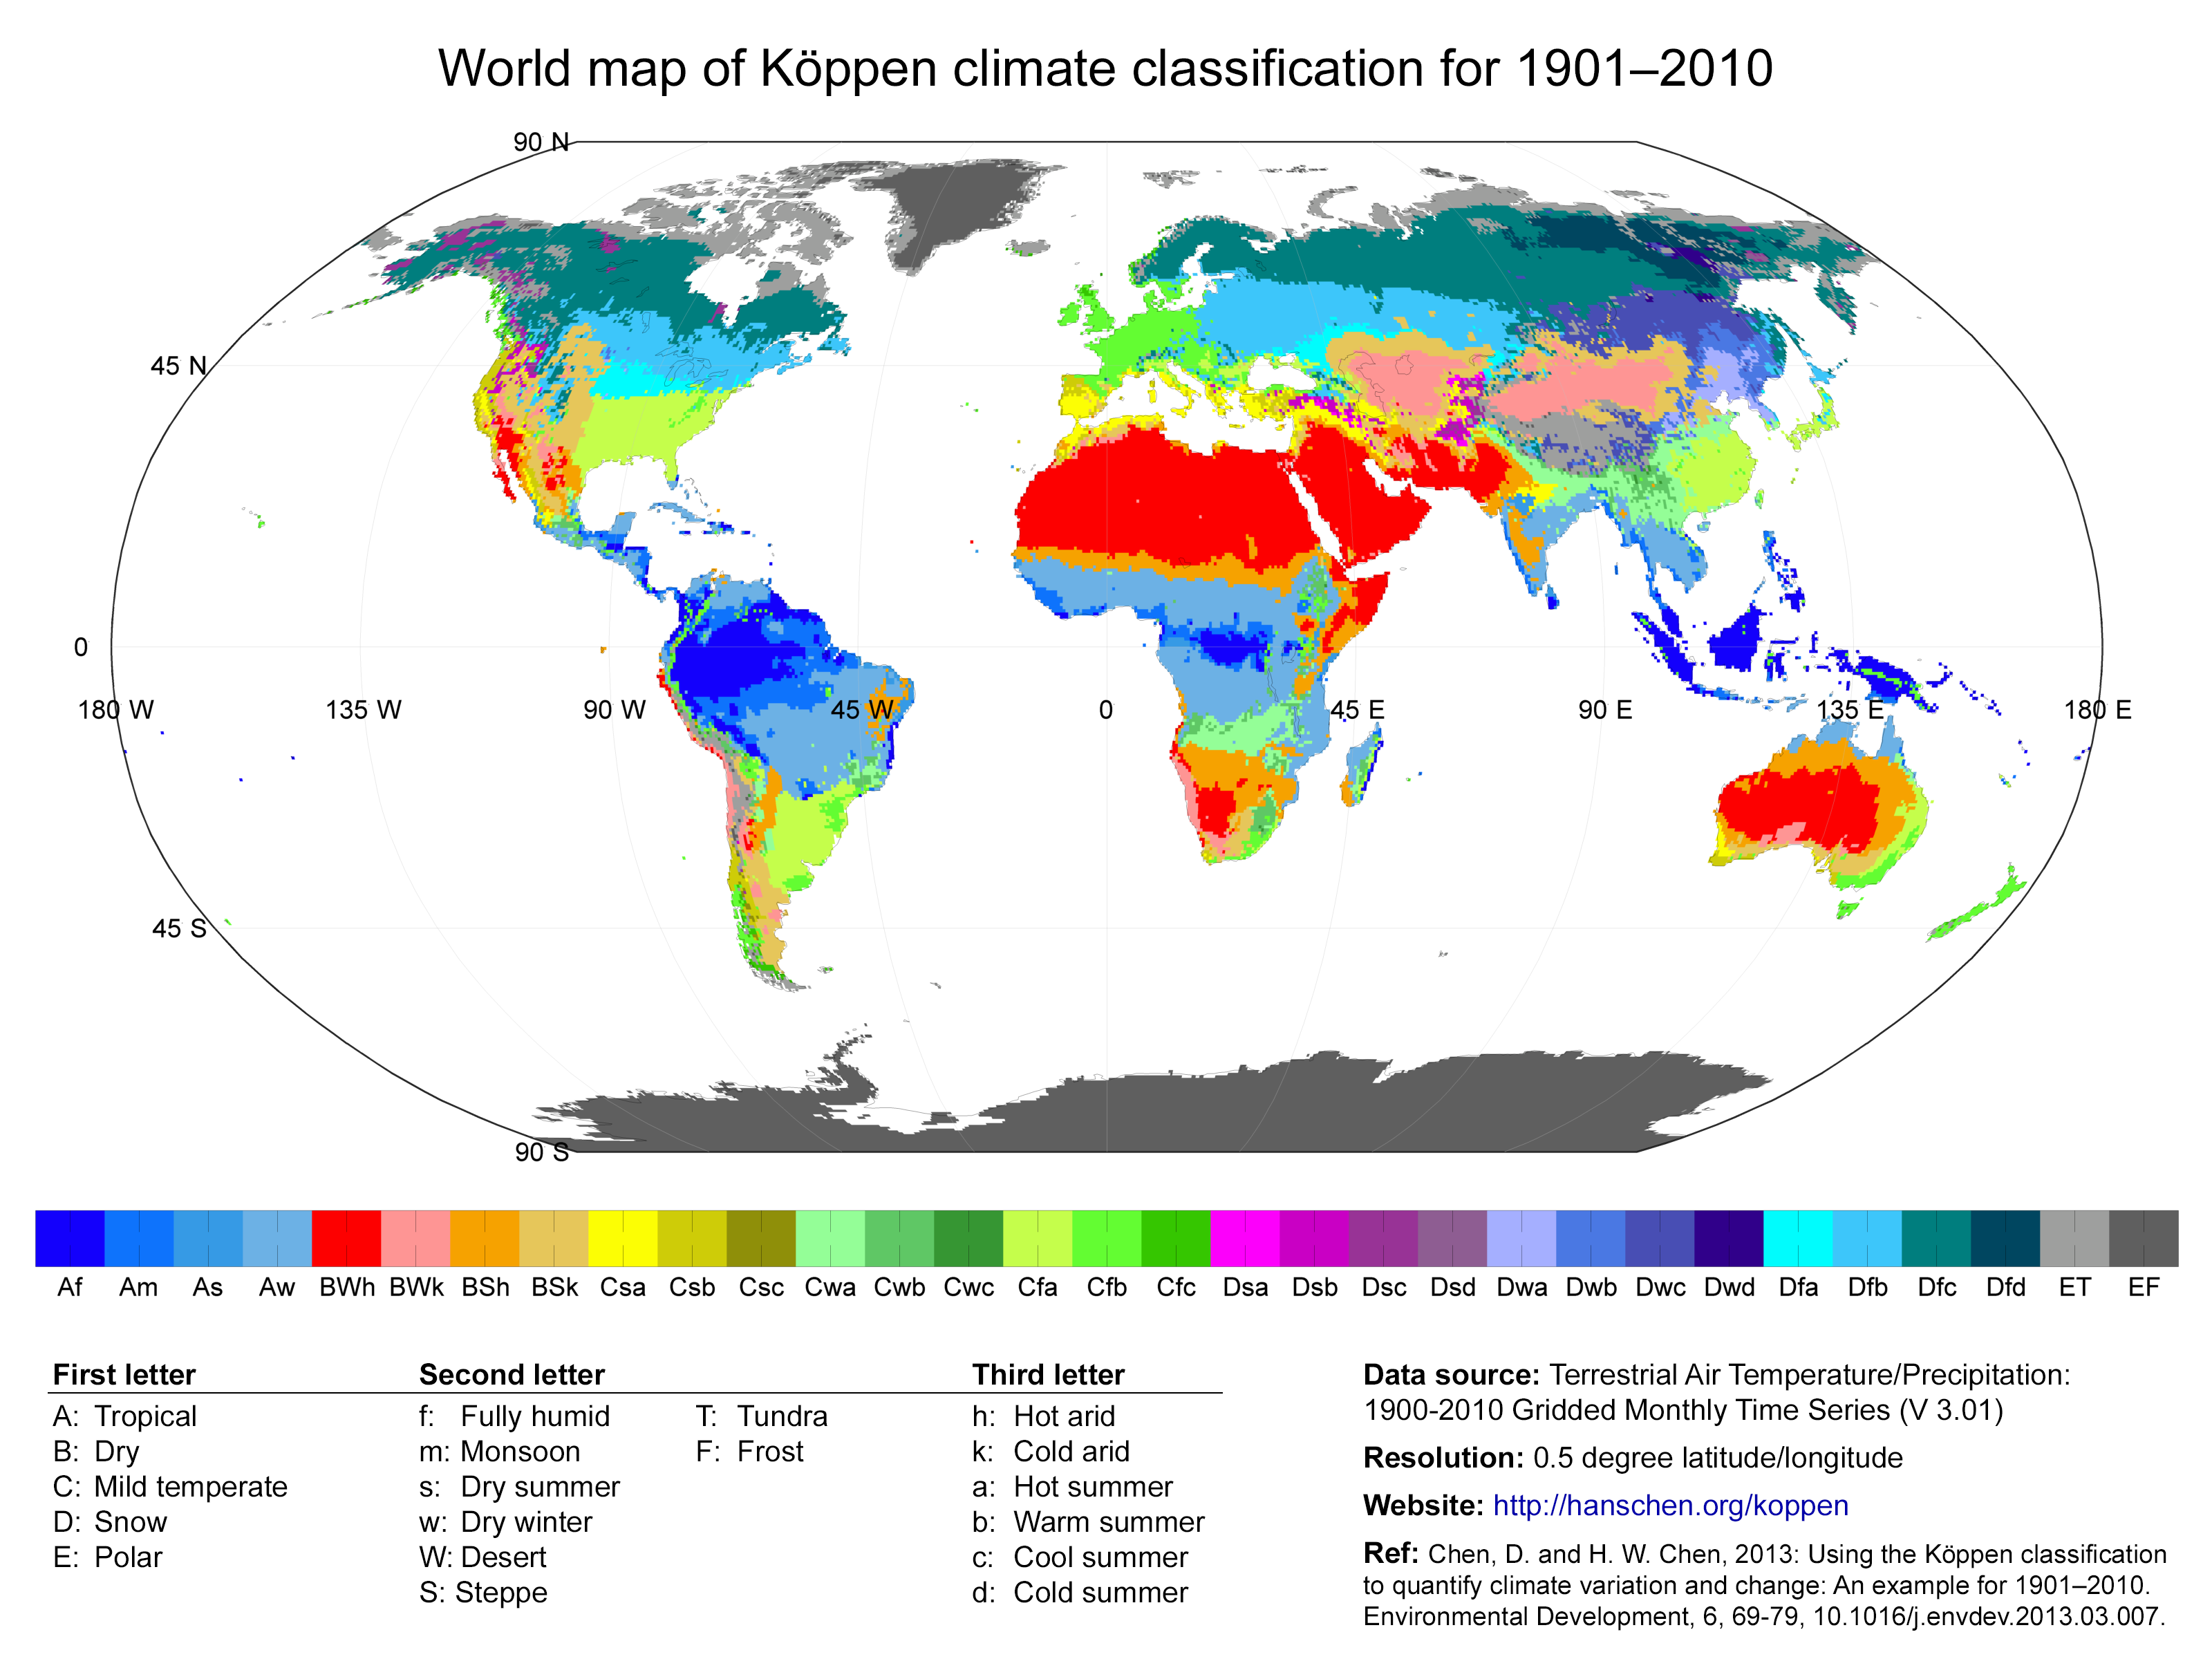